In [5]:
torch.__version__

'0.4.0'

In [1]:
import io
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import string
import random
import pdb
import nltk
from nltk import ngrams
from collections import Counter
from collections import defaultdict


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [9]:
random.seed(152)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

nowpath = os.path.abspath('.')
datapath = nowpath + '/hw2_data'
picklePath = nowpath + '/hw2_data_p'
#resPath = nowpath + '/hw2_res'
resPath = nowpath + '/hw2_res_cheatreal'
resCNN = nowpath + '/hw2_res_cheatreal_cnn/hw2_data_cheatreal'

all_train = []
all_val = []

In [5]:
def snli_reader(dataset, filepath):
    with open(filepath) as f:
        f.readline()
        lines = f.readlines()
        for line in lines:
            dataset.append([x.strip('. \n') for x in line.split('\t')])
        f.close()
        
snli_reader(all_train, datapath + '/snli_train.tsv')
snli_reader(all_val, datapath + '/snli_val.tsv')

In [8]:
def pkl_dumper(objct, file_name):
    with open(file_name, 'wb') as f:
        pkl.dump(objct, f, protocol=None)
    return

def pkl_loader(file_name):
    with open(file_name, 'rb') as f:
        objct = pkl.load(f)
    return(objct)

def pkl_dumper_model(objct, file_name):
    with open(file_name, 'w') as f:
        pkl.dump(objct, f, protocol=None)
    return

In [24]:
train_embedded_dict = pkl_loader(picklePath + '/train_embedded_dict_pad_samelen_try2.p')
val_embedded_dict = pkl_loader(picklePath + '/val_embedded_dict_pad_samelen_try2.p')

In [25]:
ae = torch.tensor([2,3,4])

In [26]:
ae.cuda()

tensor([ 2,  3,  4], device='cuda:0')

In [14]:
theBestRnnModel = GRU(emb_size=300, hidden_size=400, num_layers=1, num_classes=3, bidirectional=True, \
                 interact='sub')
theBestRnnModel.load_state_dict(torch.load(resPath + '/model_400_sub0.00020.model'))

In [52]:
theBestRnnModel.eval()

GRU(
  (rnn_c1): GRU(300, 400, batch_first=True, bidirectional=True)
  (linear_1): Linear(in_features=400, out_features=400, bias=True)
  (linear_2): Linear(in_features=400, out_features=3, bias=True)
)

In [53]:
theBestRnnModel.cuda()

GRU(
  (rnn_c1): GRU(300, 400, batch_first=True, bidirectional=True)
  (linear_1): Linear(in_features=400, out_features=400, bias=True)
  (linear_2): Linear(in_features=400, out_features=3, bias=True)
)

In [20]:
val_acc = test_model(val_loader, theBestRnnModel)

In [27]:
def predictor(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    all_predicted = []
    all_label = []
    for i, (cen_1, cen_2, lengths, labels) in enumerate(loader):
        cen_1_batch, cen_2_batch, lengths_batch, label_batch = cen_1.float().cuda(), cen_2.float().cuda(), lengths.cuda(), labels.cuda()
        outputs = F.softmax(model(cen_1_batch, cen_2_batch, lengths_batch), dim=1).cuda()
        predicted = [x.item() for x in outputs.max(1, keepdim=True)[1]]
        all_predicted += predicted
        all_label += [x.item() for x in labels]
    return (all_predicted, all_label)

In [25]:
all_pred, all_label = predictor(val_loader_NoSuffle, theBestRnnModel)

In [32]:
right_pred_recorder = []
wrong_pred_recorder = []
for i in range(300, 500):
    if all_pred[i] != all_label[i]:
        wrong_pred_recorder.append([all_val[i], all_pred[i], all_label[i]])
    else:
        right_pred_recorder.append([all_val[i], all_pred[i], all_label[i]])
    if len(wrong_pred_recorder) >= 3 and len(right_pred_recorder) >= 3:
        break

In [33]:
wrong_pred_recorder

[[['Two blond people are sitting in a park having a conversation',
   'Two brunettes are sitting in a park',
   'contradiction'],
  0,
  2],
 [['Children are playing a game outside',
   'Children are not a game',
   'contradiction'],
  1,
  2],
 [['A caucasian woman in a blue top and black slacks looks off to the side of the camera with a drink in one hand and a amused look upon her face , while a man sits next to her , looking unamused , drink in one hand , straw in the other',
   'A man and woman are having drinks in a bar',
   'neutral'],
  2,
  0]]

In [34]:
right_pred_recorder

[[['A boy is posing next to his scooter',
   'A boy is next to a scooter',
   'entailment'],
  1,
  1],
 [['Two black and white dogs looking at a black and white kitten who is sitting on top of a tank with hoses on it',
   'Some funny animals',
   'neutral'],
  0,
  0],
 [['A group of people are taking a fun train ride',
   'People ride the train',
   'entailment'],
  1,
  1],
 [['An older man is walking in a large grassy area with a small plane in the background about to land',
   'The person is sipping hot chocolate inside a skating rink',
   'contradiction'],
  2,
  2],
 [['People mingling in the foreground and background , two of them are walking towards those in the background that are positioned nearby of a building that is overshadowed by a large number of trees , while the two in the foreground are tending to a horse drawn carriage',
   'Some Amish people are fixing their carriage while other people walk or stand nearby',
   'neutral'],
  0,
  0],
 [['A female sings and plays i

In [28]:
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, cen_1, cen_2, tgt, method='concat'):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.cen_1_list, self.cen_2_list, self.target_list = cen_1, cen_2, tgt
        self.method = method
        self.interact = {
            'concat':lambda x, y: x + y
            
        }
        assert (len(self.cen_1_list) == len(self.target_list) == len(self.cen_2_list))

    def __len__(self):
        return len(self.cen_1_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        #tot_cen = self.interact[method](self.cen_1_list[key], self.cen_2_list[key])
        cen_1, cen_2 = self.cen_1_list[key], self.cen_2_list[key]
        label = self.target_list[key]
        return [cen_1, cen_2, len(cen_1) + len(cen_2), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list = []
    
    data_list_1, data_list_2, length_list, label_list = zip(*batch)

    # for datum in batch:
    #     label_list.append(datum[2])
    #     length_list.append(datum[1])
    #     data_list.append(datum[0])
    return [torch.from_numpy(np.array(data_list_1)), torch.from_numpy(np.array(data_list_2)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [29]:
train_dataset = VocabDataset(train_embedded_dict['org'], train_embedded_dict['alt'], train_embedded_dict['label'])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val_embedded_dict['org'], val_embedded_dict['alt'], val_embedded_dict['label'])
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [22]:
val_loader_NoSuffle = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [30]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, bidirectional=False, interact='concat'):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.bidirectional = bidirectional
        self.interact = interact
        if self.interact == 'concat':
            self.rnn_c1 = nn.GRU(emb_size, hidden_size//2, num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            self.rnn_c1 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, num_classes)
        
        self.interact_method = {
            'concat': lambda x, y: torch.cat((x, y), 2),
            'mult': lambda x, y: x * y,
            'sub': lambda x, y: x - y
        }

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if self.bidirectional == True:
            if self.interact == 'concat':
                hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size//2)
            else:
                hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        else:
            hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        return hidden.cuda()

    def forward(self, c1, c2, lengths):
        # reset hidden state
        #print(c1.size())
        batch_size, seq_len, emb_size = c1.size()

        self.hidden = self.init_hidden(batch_size)
        #print(self.hidden_1.size())
        c1_rnn_out, c1_hidden = self.rnn_c1(c1, self.hidden)
        c2_rnn_out, c2_hidden = self.rnn_c1(c2, self.hidden)
        
        intera_hidden = self.interact_method[self.interact](c1_hidden, c2_hidden)
        intera_hidden, _ = torch.max(intera_hidden, dim=0)
        
        l1_out = self.linear_1(intera_hidden)
        l2_out = self.linear_2(l1_out)
        
        return l2_out.cuda()


In [31]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for i, (cen_1, cen_2, lengths, labels) in enumerate(loader):
        cen_1_batch, cen_2_batch, lengths_batch, label_batch = cen_1.float().cuda(), cen_2.float().cuda(), lengths.cuda(), labels.cuda()
        outputs = F.softmax(model(cen_1_batch, cen_2_batch, lengths_batch), dim=1).cuda()
        predicted = outputs.max(1, keepdim=True)[1]
        predicted = predicted.cuda()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
    return (100 * correct / total)

def model_runner(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, bidirectional=True, \
                 interact='concat', learning_rate=2e-4, num_epochs=5, weight_decay=0):
    if 'model' in dir():
        del(model)
        
    model = GRU(emb_size=emb_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, \
                bidirectional=bidirectional, interact=interact)

    learning_rate = learning_rate
    num_epochs = num_epochs # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model.cuda()
    criterion.cuda()

    print('num_parameters:', sum(p.numel() for p in model.parameters()))
    
    # Train the model
    total_step = len(train_loader)

    train_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        for i, (cen_1, cen_2, lengths, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(cen_1.float().cuda(), cen_2.float().cuda(), lengths.cuda())
            #print(outputs.size())
            #print(labels.size())
            loss = criterion(outputs, labels.cuda())

            # Backward and optimize
            loss.backward()
            optimizer.step()
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_list.append(val_acc)
                train_loss = loss.item()
                train_loss_list.append(train_loss)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_loss, val_acc))
    pkl_dumper(train_loss_list, resPath + '/train_loss_list_' + str(hidden_size) + '_' + str(interact) + \
               str(learning_rate) + str(weight_decay) + '.p')
    pkl_dumper(val_acc_list, resPath + '/val_acc_list_' + str(hidden_size) + '_' + str(interact) + \
               str(learning_rate) + str(weight_decay) + '.p')
    torch.save(model.state_dict(), resPath + '/model_' + str(hidden_size) + '_' + str(interact) + \
               str(learning_rate) + str(weight_decay) + '.model')
    return(model, train_loss_list, val_acc_list)


In [17]:
model2, train_loss_l2, val_acc_l2 = model_runner(learning_rate = 2e-4, num_epochs = 10)

num_parameters: 282003
Epoch: [1/10], Step: [301/3125], Train Loss: 0.9912867546081543, Validation Acc: 43.6
Epoch: [1/10], Step: [601/3125], Train Loss: 0.9159111380577087, Validation Acc: 54.4
Epoch: [1/10], Step: [901/3125], Train Loss: 0.9044325351715088, Validation Acc: 56.6
Epoch: [1/10], Step: [1201/3125], Train Loss: 0.7809341549873352, Validation Acc: 55.9
Epoch: [1/10], Step: [1501/3125], Train Loss: 1.1582382917404175, Validation Acc: 57.9
Epoch: [1/10], Step: [1801/3125], Train Loss: 0.8616916537284851, Validation Acc: 57.9
Epoch: [1/10], Step: [2101/3125], Train Loss: 0.8934863209724426, Validation Acc: 55.5
Epoch: [1/10], Step: [2401/3125], Train Loss: 1.0350537300109863, Validation Acc: 56.5
Epoch: [1/10], Step: [2701/3125], Train Loss: 1.0197843313217163, Validation Acc: 57.5
Epoch: [1/10], Step: [3001/3125], Train Loss: 0.8979182243347168, Validation Acc: 57.8
Epoch: [2/10], Step: [301/3125], Train Loss: 0.8862162828445435, Validation Acc: 56.6
Epoch: [2/10], Step: [60

Epoch: [10/10], Step: [1801/3125], Train Loss: 0.7804362773895264, Validation Acc: 62.9
Epoch: [10/10], Step: [2101/3125], Train Loss: 0.7607490420341492, Validation Acc: 63.8
Epoch: [10/10], Step: [2401/3125], Train Loss: 0.6635763049125671, Validation Acc: 64.0
Epoch: [10/10], Step: [2701/3125], Train Loss: 0.6144183874130249, Validation Acc: 64.2
Epoch: [10/10], Step: [3001/3125], Train Loss: 0.5983656048774719, Validation Acc: 63.8


In [12]:
model3, train_loss_l3, val_acc_l3 = model_runner(interact='mult', learning_rate = 2e-4, num_epochs = 10)

num_parameters: 643203
Epoch: [1/10], Step: [301/3125], Train Loss: 1.0960907936096191, Validation Acc: 38.7
Epoch: [1/10], Step: [601/3125], Train Loss: 0.9661676287651062, Validation Acc: 46.1
Epoch: [1/10], Step: [901/3125], Train Loss: 0.8844318389892578, Validation Acc: 49.8
Epoch: [1/10], Step: [1201/3125], Train Loss: 1.2443158626556396, Validation Acc: 50.2
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.9083905816078186, Validation Acc: 52.5
Epoch: [1/10], Step: [1801/3125], Train Loss: 0.8376584053039551, Validation Acc: 54.0
Epoch: [1/10], Step: [2101/3125], Train Loss: 0.8883495330810547, Validation Acc: 54.9
Epoch: [1/10], Step: [2401/3125], Train Loss: 0.8482031226158142, Validation Acc: 53.6
Epoch: [1/10], Step: [2701/3125], Train Loss: 1.0582305192947388, Validation Acc: 55.6
Epoch: [1/10], Step: [3001/3125], Train Loss: 1.0084121227264404, Validation Acc: 55.1
Epoch: [2/10], Step: [301/3125], Train Loss: 0.9531611204147339, Validation Acc: 57.9
Epoch: [2/10], Step: [60

Epoch: [10/10], Step: [1801/3125], Train Loss: 0.7073751091957092, Validation Acc: 67.9
Epoch: [10/10], Step: [2101/3125], Train Loss: 0.5031074285507202, Validation Acc: 69.0
Epoch: [10/10], Step: [2401/3125], Train Loss: 0.9137710928916931, Validation Acc: 67.1
Epoch: [10/10], Step: [2701/3125], Train Loss: 0.4852893352508545, Validation Acc: 68.4
Epoch: [10/10], Step: [3001/3125], Train Loss: 0.5157069563865662, Validation Acc: 69.2


In [13]:
model4, train_loss_l3, val_acc_l3 = model_runner(interact='sub', learning_rate = 2e-4, num_epochs = 10)

num_parameters: 643203
Epoch: [1/10], Step: [301/3125], Train Loss: 1.074378490447998, Validation Acc: 47.4
Epoch: [1/10], Step: [601/3125], Train Loss: 1.004145622253418, Validation Acc: 55.2
Epoch: [1/10], Step: [901/3125], Train Loss: 0.9472140669822693, Validation Acc: 54.7
Epoch: [1/10], Step: [1201/3125], Train Loss: 1.0112487077713013, Validation Acc: 57.1
Epoch: [1/10], Step: [1501/3125], Train Loss: 1.0186197757720947, Validation Acc: 57.5
Epoch: [1/10], Step: [1801/3125], Train Loss: 0.9287655353546143, Validation Acc: 57.9
Epoch: [1/10], Step: [2101/3125], Train Loss: 0.6722450256347656, Validation Acc: 61.8
Epoch: [1/10], Step: [2401/3125], Train Loss: 0.9134912490844727, Validation Acc: 62.7
Epoch: [1/10], Step: [2701/3125], Train Loss: 0.8410914540290833, Validation Acc: 62.3
Epoch: [1/10], Step: [3001/3125], Train Loss: 0.7634693384170532, Validation Acc: 62.6
Epoch: [2/10], Step: [301/3125], Train Loss: 0.7790877223014832, Validation Acc: 64.1
Epoch: [2/10], Step: [601/

Epoch: [10/10], Step: [1801/3125], Train Loss: 0.39226922392845154, Validation Acc: 74.4
Epoch: [10/10], Step: [2101/3125], Train Loss: 0.2529647946357727, Validation Acc: 75.0
Epoch: [10/10], Step: [2401/3125], Train Loss: 0.7449542284011841, Validation Acc: 75.8
Epoch: [10/10], Step: [2701/3125], Train Loss: 0.506772518157959, Validation Acc: 74.7
Epoch: [10/10], Step: [3001/3125], Train Loss: 0.16472184658050537, Validation Acc: 74.7


In [14]:
model2, train_loss_l2, val_acc_l2 = model_runner(interact='sub', hidden_size = 50, learning_rate = 2e-4, num_epochs = 10)

num_parameters: 108303
Epoch: [1/10], Step: [301/3125], Train Loss: 1.0609352588653564, Validation Acc: 44.0
Epoch: [1/10], Step: [601/3125], Train Loss: 1.157028079032898, Validation Acc: 46.6
Epoch: [1/10], Step: [901/3125], Train Loss: 1.0362067222595215, Validation Acc: 49.3
Epoch: [1/10], Step: [1201/3125], Train Loss: 0.909479022026062, Validation Acc: 51.6
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.9692710638046265, Validation Acc: 53.2
Epoch: [1/10], Step: [1801/3125], Train Loss: 0.7934401631355286, Validation Acc: 56.0
Epoch: [1/10], Step: [2101/3125], Train Loss: 0.7626508474349976, Validation Acc: 55.4
Epoch: [1/10], Step: [2401/3125], Train Loss: 1.0378224849700928, Validation Acc: 56.9
Epoch: [1/10], Step: [2701/3125], Train Loss: 0.8697634339332581, Validation Acc: 56.7
Epoch: [1/10], Step: [3001/3125], Train Loss: 0.8843826651573181, Validation Acc: 56.3
Epoch: [2/10], Step: [301/3125], Train Loss: 0.7084231972694397, Validation Acc: 57.5
Epoch: [2/10], Step: [601/

Epoch: [10/10], Step: [1801/3125], Train Loss: 0.5703100562095642, Validation Acc: 71.0
Epoch: [10/10], Step: [2101/3125], Train Loss: 0.5866490602493286, Validation Acc: 70.6
Epoch: [10/10], Step: [2401/3125], Train Loss: 0.5113466382026672, Validation Acc: 70.1
Epoch: [10/10], Step: [2701/3125], Train Loss: 0.6143627166748047, Validation Acc: 71.4
Epoch: [10/10], Step: [3001/3125], Train Loss: 0.5719237327575684, Validation Acc: 70.1


In [15]:
model2, train_loss_l2, val_acc_l2 = model_runner(interact='sub', hidden_size = 400, learning_rate = 2e-4, num_epochs = 10)

num_parameters: 1846403
Epoch: [1/10], Step: [301/3125], Train Loss: 1.0485177040100098, Validation Acc: 53.0
Epoch: [1/10], Step: [601/3125], Train Loss: 0.8706165552139282, Validation Acc: 55.1
Epoch: [1/10], Step: [901/3125], Train Loss: 0.7907001972198486, Validation Acc: 58.1
Epoch: [1/10], Step: [1201/3125], Train Loss: 0.7411497831344604, Validation Acc: 55.7
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.8115754723548889, Validation Acc: 59.5
Epoch: [1/10], Step: [1801/3125], Train Loss: 0.7568837404251099, Validation Acc: 62.7
Epoch: [1/10], Step: [2101/3125], Train Loss: 0.8058845400810242, Validation Acc: 63.3
Epoch: [1/10], Step: [2401/3125], Train Loss: 0.9318096041679382, Validation Acc: 63.7
Epoch: [1/10], Step: [2701/3125], Train Loss: 0.6370952725410461, Validation Acc: 64.5
Epoch: [1/10], Step: [3001/3125], Train Loss: 0.8542386293411255, Validation Acc: 64.6
Epoch: [2/10], Step: [301/3125], Train Loss: 0.8670735955238342, Validation Acc: 64.7
Epoch: [2/10], Step: [6

Epoch: [10/10], Step: [1801/3125], Train Loss: 0.4038519263267517, Validation Acc: 75.6
Epoch: [10/10], Step: [2101/3125], Train Loss: 0.30811381340026855, Validation Acc: 74.5
Epoch: [10/10], Step: [2401/3125], Train Loss: 0.23661236464977264, Validation Acc: 76.6
Epoch: [10/10], Step: [2701/3125], Train Loss: 0.26677805185317993, Validation Acc: 74.7
Epoch: [10/10], Step: [3001/3125], Train Loss: 0.630548357963562, Validation Acc: 74.0


In [16]:
model5, train_loss_l5, val_acc_l5 = model_runner(interact='sub', hidden_size = 400, learning_rate = 2e-4, num_epochs = 10, weight_decay = 0.001)

num_parameters: 1846403
Epoch: [1/10], Step: [301/3125], Train Loss: 1.05595064163208, Validation Acc: 46.4
Epoch: [1/10], Step: [601/3125], Train Loss: 1.0379722118377686, Validation Acc: 54.3
Epoch: [1/10], Step: [901/3125], Train Loss: 0.9068751335144043, Validation Acc: 54.6
Epoch: [1/10], Step: [1201/3125], Train Loss: 0.9949344992637634, Validation Acc: 55.0
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.9519407749176025, Validation Acc: 57.7
Epoch: [1/10], Step: [1801/3125], Train Loss: 0.8538222312927246, Validation Acc: 54.8
Epoch: [1/10], Step: [2101/3125], Train Loss: 0.8319931030273438, Validation Acc: 55.4
Epoch: [1/10], Step: [2401/3125], Train Loss: 0.7853331565856934, Validation Acc: 57.3
Epoch: [1/10], Step: [2701/3125], Train Loss: 0.7794667482376099, Validation Acc: 56.0
Epoch: [1/10], Step: [3001/3125], Train Loss: 1.009045124053955, Validation Acc: 57.4
Epoch: [2/10], Step: [301/3125], Train Loss: 1.0115958452224731, Validation Acc: 58.2
Epoch: [2/10], Step: [601/

Epoch: [10/10], Step: [1801/3125], Train Loss: 0.6071631908416748, Validation Acc: 68.8
Epoch: [10/10], Step: [2101/3125], Train Loss: 0.4617745280265808, Validation Acc: 69.3
Epoch: [10/10], Step: [2401/3125], Train Loss: 0.5717781186103821, Validation Acc: 69.6
Epoch: [10/10], Step: [2701/3125], Train Loss: 0.8022764921188354, Validation Acc: 70.2
Epoch: [10/10], Step: [3001/3125], Train Loss: 0.7899577617645264, Validation Acc: 69.1


In [32]:
## Train acc version

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for i, (cen_1, cen_2, lengths, labels) in enumerate(loader):
        cen_1_batch, cen_2_batch, lengths_batch, label_batch = cen_1.float().cuda(), cen_2.float().cuda(), lengths.cuda(), labels.cuda()
        outputs = F.softmax(model(cen_1_batch, cen_2_batch, lengths_batch), dim=1).cuda()
        predicted = outputs.max(1, keepdim=True)[1]
        predicted = predicted.cuda()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
    return (100 * correct / total)

def model_runner(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, bidirectional=True, \
                 interact='concat', learning_rate=2e-4, num_epochs=5, weight_decay=0):
    if 'model' in dir():
        del(model)
        
    model = GRU(emb_size=emb_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, \
                bidirectional=bidirectional, interact=interact)

    learning_rate = learning_rate
    num_epochs = num_epochs # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model.cuda()
    criterion.cuda()

    print('num_parameters:', sum(p.numel() for p in model.parameters()))
    
    # Train the model
    total_step = len(train_loader)

    train_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        for i, (cen_1, cen_2, lengths, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(cen_1.float().cuda(), cen_2.float().cuda(), lengths.cuda())
            #print(outputs.size())
            #print(labels.size())
            loss = criterion(outputs, labels.cuda())

            # Backward and optimize
            loss.backward()
            optimizer.step()
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_list.append(val_acc)
                correct = 0
                total = 0
                outputs = F.softmax(model(cen_1.float().cuda(), cen_2.float().cuda(), lengths.cuda()), dim=1).cuda()
                predicted = outputs.max(1, keepdim=True)[1]
                predicted = predicted.cuda()
                total += labels.size(0)
                correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
                train_loss = 100 * correct/total
                train_loss_list.append(train_loss)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_loss, val_acc))
    pkl_dumper(train_loss_list, resPath + '/train_loss_list_' + str(hidden_size) + '_' + str(interact) + \
               str(learning_rate) + str(weight_decay) + '.p')
    pkl_dumper(val_acc_list, resPath + '/val_acc_list_' + str(hidden_size) + '_' + str(interact) + \
               str(learning_rate) + str(weight_decay) + '.p')
    torch.save(model.state_dict(), resPath + '/model_' + str(hidden_size) + '_' + str(interact) + \
               str(learning_rate) + str(weight_decay) + '.model')
    return(model, train_loss_list, val_acc_list)


In [ ]:
model55, train_loss_l55, val_acc_l55 = model_runner(interact='concat', hidden_size = 200, learning_rate = 2e-4, num_epochs = 10)

num_parameters: 282003
Epoch: [1/10], Step: [301/3125], Train Acc: 37.5, Validation Acc: 44.3
Epoch: [1/10], Step: [601/3125], Train Acc: 50.0, Validation Acc: 53.9
Epoch: [1/10], Step: [901/3125], Train Acc: 62.5, Validation Acc: 57.6
Epoch: [1/10], Step: [1201/3125], Train Acc: 62.5, Validation Acc: 56.4
Epoch: [1/10], Step: [1501/3125], Train Acc: 59.375, Validation Acc: 57.4
Epoch: [1/10], Step: [1801/3125], Train Acc: 71.875, Validation Acc: 58.7
Epoch: [1/10], Step: [2101/3125], Train Acc: 53.125, Validation Acc: 58.0
Epoch: [1/10], Step: [2401/3125], Train Acc: 71.875, Validation Acc: 57.8
Epoch: [1/10], Step: [2701/3125], Train Acc: 53.125, Validation Acc: 57.6
Epoch: [1/10], Step: [3001/3125], Train Acc: 50.0, Validation Acc: 57.7
Epoch: [2/10], Step: [301/3125], Train Acc: 68.75, Validation Acc: 58.6
Epoch: [2/10], Step: [601/3125], Train Acc: 68.75, Validation Acc: 58.0
Epoch: [2/10], Step: [901/3125], Train Acc: 65.625, Validation Acc: 59.0
Epoch: [2/10], Step: [1201/3125],

In [ ]:
model55, train_loss_l55, val_acc_l55 = model_runner(interact='mult', hidden_size = 200, learning_rate = 2e-4, num_epochs = 10)

In [33]:
model66, train_loss_l66, val_acc_l66 = model_runner(interact='sub', hidden_size = 200, learning_rate = 2e-4, num_epochs = 10)

num_parameters: 643203
Epoch: [1/10], Step: [301/3125], Train Acc: 43.75, Validation Acc: 48.7
Epoch: [1/10], Step: [601/3125], Train Acc: 46.875, Validation Acc: 53.4
Epoch: [1/10], Step: [901/3125], Train Acc: 50.0, Validation Acc: 57.1
Epoch: [1/10], Step: [1201/3125], Train Acc: 68.75, Validation Acc: 58.2
Epoch: [1/10], Step: [1501/3125], Train Acc: 78.125, Validation Acc: 58.3
Epoch: [1/10], Step: [1801/3125], Train Acc: 59.375, Validation Acc: 57.8
Epoch: [1/10], Step: [2101/3125], Train Acc: 59.375, Validation Acc: 59.8
Epoch: [1/10], Step: [2401/3125], Train Acc: 56.25, Validation Acc: 61.8
Epoch: [1/10], Step: [2701/3125], Train Acc: 50.0, Validation Acc: 62.3
Epoch: [1/10], Step: [3001/3125], Train Acc: 75.0, Validation Acc: 63.5
Epoch: [2/10], Step: [301/3125], Train Acc: 81.25, Validation Acc: 64.4
Epoch: [2/10], Step: [601/3125], Train Acc: 71.875, Validation Acc: 65.5
Epoch: [2/10], Step: [901/3125], Train Acc: 62.5, Validation Acc: 65.5
Epoch: [2/10], Step: [1201/3125],

In [34]:
model77, train_loss_l77, val_acc_l77 = model_runner(interact='sub', hidden_size = 50, learning_rate = 2e-4, num_epochs = 10)

num_parameters: 108303
Epoch: [1/10], Step: [301/3125], Train Acc: 34.375, Validation Acc: 39.4
Epoch: [1/10], Step: [601/3125], Train Acc: 56.25, Validation Acc: 48.5
Epoch: [1/10], Step: [901/3125], Train Acc: 53.125, Validation Acc: 50.2
Epoch: [1/10], Step: [1201/3125], Train Acc: 53.125, Validation Acc: 52.5
Epoch: [1/10], Step: [1501/3125], Train Acc: 62.5, Validation Acc: 55.9
Epoch: [1/10], Step: [1801/3125], Train Acc: 62.5, Validation Acc: 56.2
Epoch: [1/10], Step: [2101/3125], Train Acc: 53.125, Validation Acc: 57.3
Epoch: [1/10], Step: [2401/3125], Train Acc: 65.625, Validation Acc: 57.5
Epoch: [1/10], Step: [2701/3125], Train Acc: 56.25, Validation Acc: 58.1
Epoch: [1/10], Step: [3001/3125], Train Acc: 75.0, Validation Acc: 58.4
Epoch: [2/10], Step: [301/3125], Train Acc: 62.5, Validation Acc: 58.5
Epoch: [2/10], Step: [601/3125], Train Acc: 53.125, Validation Acc: 57.8
Epoch: [2/10], Step: [901/3125], Train Acc: 71.875, Validation Acc: 58.9
Epoch: [2/10], Step: [1201/3125

In [35]:
model11, train_loss_l11, val_acc_l11 = model_runner(interact='sub', hidden_size = 400, learning_rate = 2e-4, num_epochs = 10)

num_parameters: 1846403
Epoch: [1/10], Step: [301/3125], Train Acc: 65.625, Validation Acc: 53.4
Epoch: [1/10], Step: [601/3125], Train Acc: 62.5, Validation Acc: 55.2
Epoch: [1/10], Step: [901/3125], Train Acc: 50.0, Validation Acc: 56.0
Epoch: [1/10], Step: [1201/3125], Train Acc: 62.5, Validation Acc: 58.4
Epoch: [1/10], Step: [1501/3125], Train Acc: 68.75, Validation Acc: 59.4
Epoch: [1/10], Step: [1801/3125], Train Acc: 78.125, Validation Acc: 62.6
Epoch: [1/10], Step: [2101/3125], Train Acc: 68.75, Validation Acc: 63.2
Epoch: [1/10], Step: [2401/3125], Train Acc: 75.0, Validation Acc: 65.5
Epoch: [1/10], Step: [2701/3125], Train Acc: 71.875, Validation Acc: 65.1
Epoch: [1/10], Step: [3001/3125], Train Acc: 68.75, Validation Acc: 65.6
Epoch: [2/10], Step: [301/3125], Train Acc: 65.625, Validation Acc: 67.1
Epoch: [2/10], Step: [601/3125], Train Acc: 71.875, Validation Acc: 66.5
Epoch: [2/10], Step: [901/3125], Train Acc: 65.625, Validation Acc: 68.9
Epoch: [2/10], Step: [1201/3125

In [36]:
model22, train_loss_l22, val_acc_l22 = model_runner(interact='sub', hidden_size = 400, learning_rate = 2e-4, num_epochs = 10, weight_decay = 0.001)

num_parameters: 1846403
Epoch: [1/10], Step: [301/3125], Train Acc: 53.125, Validation Acc: 47.1
Epoch: [1/10], Step: [601/3125], Train Acc: 56.25, Validation Acc: 53.0
Epoch: [1/10], Step: [901/3125], Train Acc: 56.25, Validation Acc: 56.3
Epoch: [1/10], Step: [1201/3125], Train Acc: 65.625, Validation Acc: 54.4
Epoch: [1/10], Step: [1501/3125], Train Acc: 50.0, Validation Acc: 56.3
Epoch: [1/10], Step: [1801/3125], Train Acc: 59.375, Validation Acc: 55.0
Epoch: [1/10], Step: [2101/3125], Train Acc: 68.75, Validation Acc: 57.7
Epoch: [1/10], Step: [2401/3125], Train Acc: 68.75, Validation Acc: 58.8
Epoch: [1/10], Step: [2701/3125], Train Acc: 59.375, Validation Acc: 60.9
Epoch: [1/10], Step: [3001/3125], Train Acc: 71.875, Validation Acc: 61.2
Epoch: [2/10], Step: [301/3125], Train Acc: 59.375, Validation Acc: 61.4
Epoch: [2/10], Step: [601/3125], Train Acc: 62.5, Validation Acc: 60.7
Epoch: [2/10], Step: [901/3125], Train Acc: 75.0, Validation Acc: 62.0
Epoch: [2/10], Step: [1201/312

In [ ]:
## Result plotting

In [37]:
TLConcH200 = pkl_loader(resPath + '/train_loss_list_200_concat0.00020.p')
VAConcH200 = pkl_loader(resPath + '/val_acc_list_200_concat0.00020.p')
TLMultH200 = pkl_loader(resPath + '/train_loss_list_200_mult0.00020.p')
VAMultH200 = pkl_loader(resPath + '/val_acc_list_200_mult0.00020.p')
TLSubH200 = pkl_loader(resPath + '/train_loss_list_200_sub0.00020.p')
VASubH200 = pkl_loader(resPath + '/val_acc_list_200_sub0.00020.p')
TLSubH50 = pkl_loader(resPath + '/train_loss_list_50_sub0.00020.p')
VASubH50 = pkl_loader(resPath + '/val_acc_list_50_sub0.00020.p')
TLSubH400 = pkl_loader(resPath + '/train_loss_list_400_sub0.00020.p')
VASubH400 = pkl_loader(resPath + '/val_acc_list_400_sub0.00020.p')
TLSubH400WD = pkl_loader(resPath + '/train_loss_list_400_sub0.00020.001.p')
VASubH400WD = pkl_loader(resPath + '/val_acc_list_400_sub0.00020.001.p')

In [11]:
from collections import defaultdict
allRnnRes = defaultdict(dict)
allRnnRes['trainLoss']['sizeHidLayer'] = [(TLSubH50, '50'), (TLSubH200, '200'), (TLSubH400, '400')]
allRnnRes['valAcc']['sizeHidLayer'] = [(VASubH50, '50'), (VASubH200, '200'), (VASubH400, '400')]
allRnnRes['trainLoss']['methodInteract'] = [(TLConcH200, 'Concat'), (TLMultH200, 'Mult'), (TLSubH200, 'Subtra')]
allRnnRes['valAcc']['methodInteract'] = [(VAConcH200, 'Concat'), (VAMultH200, 'Mult'), (VASubH200, 'Subtra')]
allRnnRes['trainLoss']['weightDecay'] = [(TLSubH400, 'no weight decay'), (TLSubH400WD, 'with weight decay')]
allRnnRes['valAcc']['weightDecay'] = [(VASubH400, 'no weight decay'), (VASubH400WD, 'with weight decay')]

NameError: name 'VASubH50' is not defined

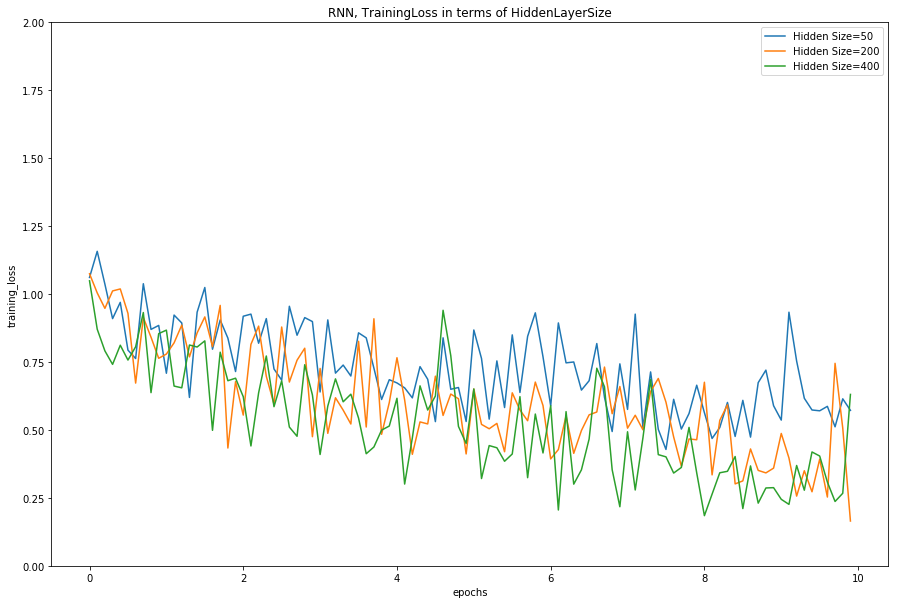

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['trainLoss']['sizeHidLayer']:
        y = data
        label = "Hidden Size="+str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, TrainingLoss in terms of HiddenLayerSize')
plt.xlabel('epochs')
plt.ylabel('training_loss')
plt.ylim(0,2)
plt.show()

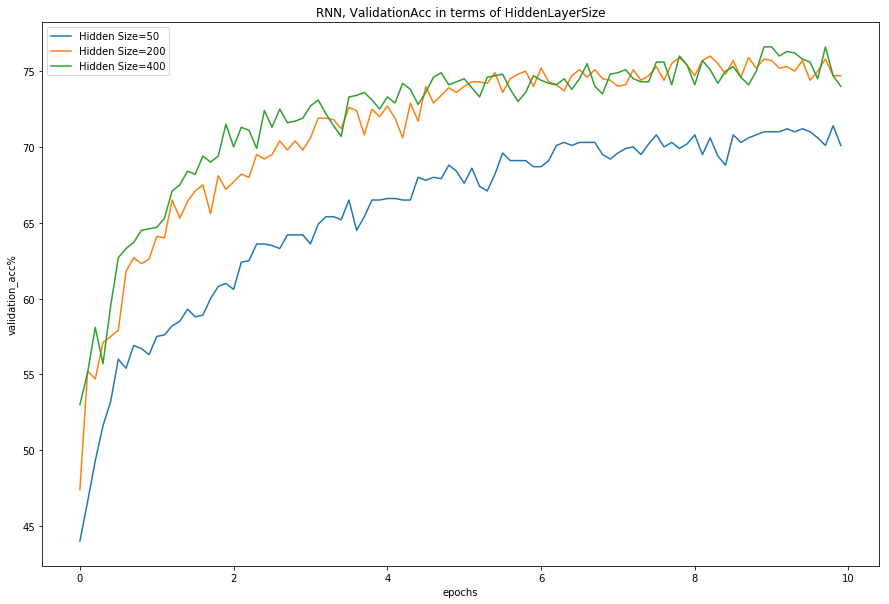

In [45]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['valAcc']['sizeHidLayer']:
        y = data
        label = "Hidden Size="+str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, ValidationAcc in terms of HiddenLayerSize')
plt.xlabel('epochs')
plt.ylabel('validation_acc%')
#plt.ylim(0,45)
plt.show()

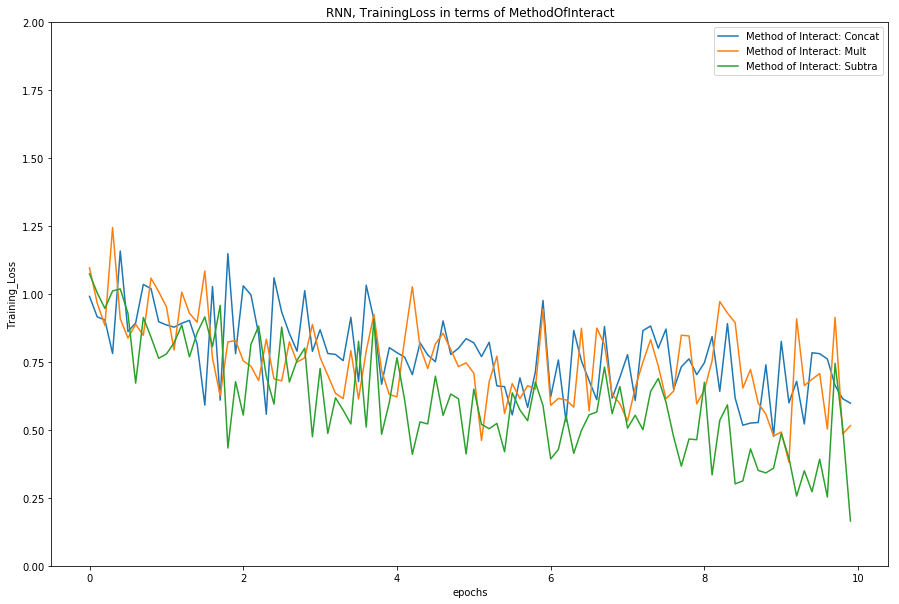

In [49]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['trainLoss']['methodInteract']:
        y = data
        label = "Method of Interact: "+str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, TrainingLoss in terms of MethodOfInteract')
plt.xlabel('epochs')
plt.ylabel('Training_Loss')
plt.ylim(0,2)
plt.show()

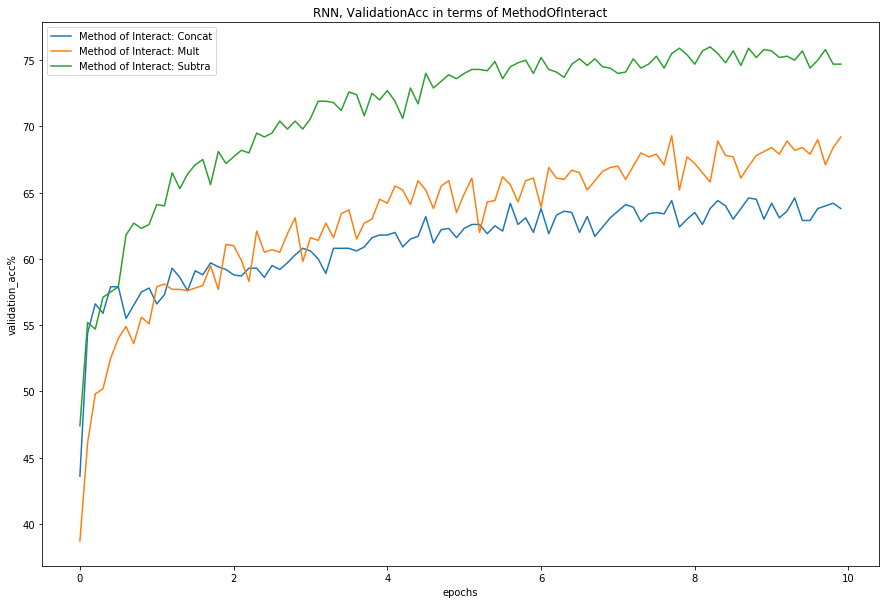

In [48]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['valAcc']['methodInteract']:
        y = data
        label = "Method of Interact: "+str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, ValidationAcc in terms of MethodOfInteract')
plt.xlabel('epochs')
plt.ylabel('validation_acc%')
#plt.ylim(0,45)
plt.show()

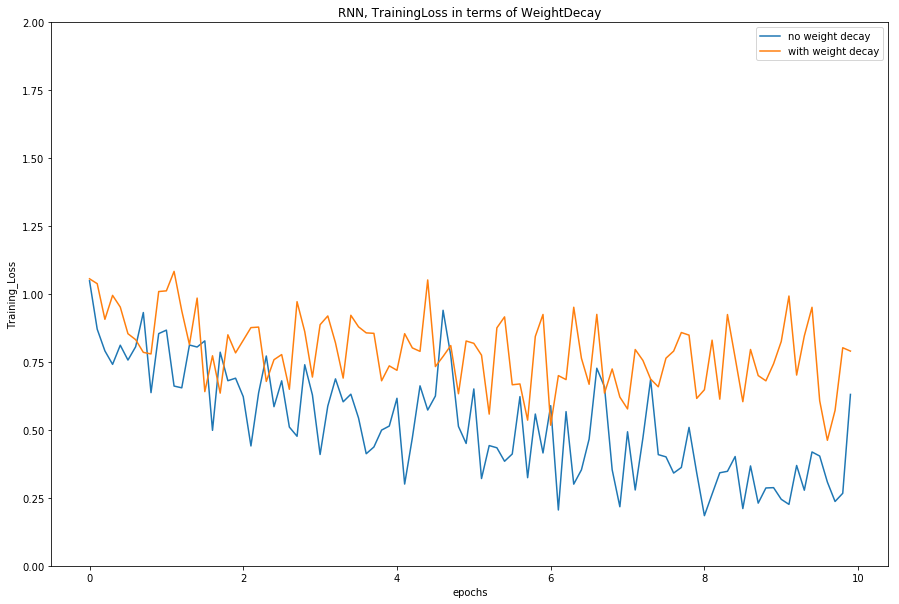

In [51]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['trainLoss']['weightDecay']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, TrainingLoss in terms of WeightDecay')
plt.xlabel('epochs')
plt.ylabel('Training_Loss')
plt.ylim(0,2)
plt.show()

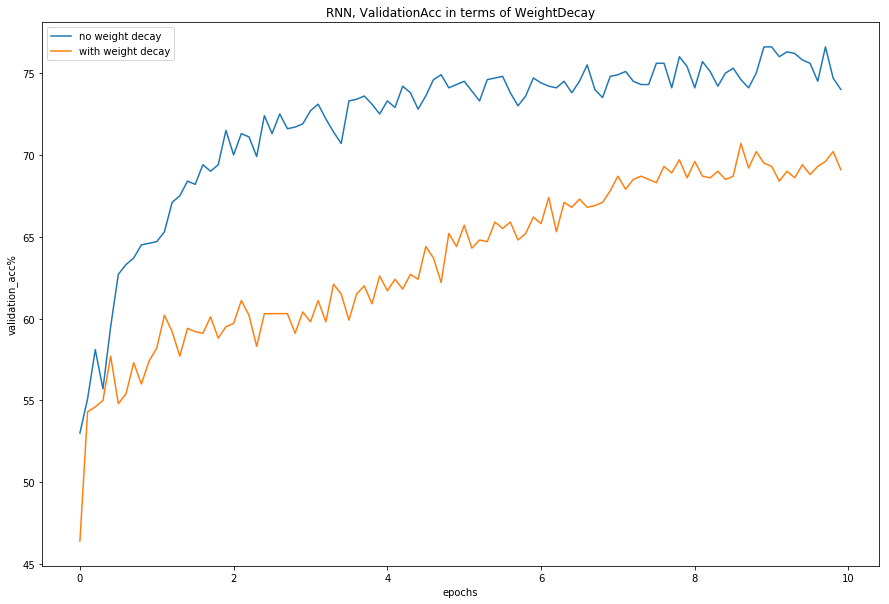

In [52]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['valAcc']['weightDecay']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, ValidationAcc in terms of WeightDecay')
plt.xlabel('epochs')
plt.ylabel('validation_acc%')
#plt.ylim(0,45)
plt.show()

In [15]:
## Test on MultiNLI
train_embedded_dict_M = pkl_loader(picklePath + '/train_embedded_dict_pad_samelen_M_try2.p')
val_embedded_dict_M = pkl_loader(picklePath + '/val_embedded_dict_pad_samelen_M_try2.p')

In [58]:
# Split the MNLI into 5 sub datasets
train_dataset_M, val_dataset_M = defaultdict(dict), defaultdict(dict)
for genre in Counter(train_embedded_dict_M['genre']).keys():
    train_dataset_M[genre] = {'org': [], 'alt': [], 'label': []}
    val_dataset_M[genre] = {'org': [], 'alt': [], 'label': []}

In [59]:
for i, genre in enumerate(train_embedded_dict_M['genre']):
    train_dataset_M[genre]['org'].append(train_embedded_dict_M['org'][i])
    train_dataset_M[genre]['alt'].append(train_embedded_dict_M['alt'][i])
    train_dataset_M[genre]['label'].append(train_embedded_dict_M['label'][i])
for i, genre in enumerate(val_embedded_dict_M['genre']):
    val_dataset_M[genre]['org'].append(val_embedded_dict_M['org'][i])
    val_dataset_M[genre]['alt'].append(val_embedded_dict_M['alt'][i])
    val_dataset_M[genre]['label'].append(val_embedded_dict_M['label'][i])

In [60]:
print(train_dataset_M.keys(), val_dataset_M.keys())

dict_keys(['telephone', 'fiction', 'slate', 'government', 'travel']) dict_keys(['telephone', 'fiction', 'slate', 'government', 'travel'])


In [62]:
train_dataset_MNLI, train_loader_MNLI, val_dataset_MNLI, val_loader_MNLI = {}, {}, {}, {}

In [63]:
#Data Loader
for genre in train_dataset_M.keys():
    train_dataset_MNLI[genre] = VocabDataset(train_dataset_M[genre]['org'], train_dataset_M[genre]['alt'], train_dataset_M[genre]['label'])
    train_loader_MNLI[genre] = torch.utils.data.DataLoader(dataset=train_dataset_MNLI[genre],
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=True)

    val_dataset_MNLI[genre] = VocabDataset(val_dataset_M[genre]['org'], val_dataset_M[genre]['alt'], val_dataset_M[genre]['label'])
    val_loader_MNLI[genre] = torch.utils.data.DataLoader(dataset=val_dataset_MNLI[genre],
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=True)

In [64]:
train_dataset_M_all = VocabDataset(train_embedded_dict_M['org'], train_embedded_dict_M['alt'], train_embedded_dict_M['label'])
train_loader_M_all = torch.utils.data.DataLoader(dataset=train_dataset_M_all,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset_M_all = VocabDataset(val_embedded_dict_M['org'], val_embedded_dict_M['alt'], val_embedded_dict_M['label'])
val_loader_M_all = torch.utils.data.DataLoader(dataset=val_dataset_M_all,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [66]:
rnnMNLIRes = {}
for genre in train_dataset_M.keys():
    rnnMNLIRes[genre] = test_model(val_loader_MNLI[genre], theBestRnnModel)
rnnMNLIRes['all'] = test_model(val_loader_M_all, theBestRnnModel)

In [67]:
rnnMNLIRes

{'telephone': 48.656716417910445,
 'fiction': 49.74874371859296,
 'slate': 47.10578842315369,
 'government': 48.62204724409449,
 'travel': 49.389002036659875,
 'all': 48.74}

In [54]:
test_model(val_loader_M_all, theBestRnnModel)

48.72

In [49]:
val_loader_M.keys()

dict_keys([])

In [70]:
## Best CNN Model
theBestCnnModel = CNN(emb_size=300, hidden_size=300, num_layers=1, num_classes=3, kernel_size=7, padding_size=3, \
                     interact='concat', len_sen=78)
theBestCnnModel.load_state_dict(torch.load(resPath + '/model_300_7_concat0.00020.model'))
theBestCnnModel.eval()
theBestCnnModel.cuda()

CNN(
  (conv1): Conv1d(300, 300, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(300, 300, kernel_size=(7,), stride=(1,), padding=(3,))
  (linear_1): Linear(in_features=156, out_features=78, bias=True)
  (linear_2): Linear(in_features=78, out_features=3, bias=True)
)

In [68]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, kernel_size, padding_size, len_sen, interact='concat'):
        super(CNN, self).__init__()
        self.len_sen = len_sen
        self.interact = interact
        self.Lout_size = self.len_sen + 2*padding_size - 1*(kernel_size-1) 
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=padding_size)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding_size)
        if self.interact == 'concat':
            self.linear_1 = nn.Linear(self.Lout_size * 2, self.Lout_size)
        else:
            self.linear_1 = nn.Linear(self.Lout_size, self.Lout_size)
        self.linear_2 = nn.Linear(self.Lout_size, num_classes)
        self.interact_method = {
            'concat': lambda x, y: torch.cat((x, y), 1),
            'mult': lambda x, y: x * y,
            'sub': lambda x, y: x - y
        }

    def forward(self, c1, c2, lengths):
        batch_size, seq_len, emb_size = c1.size()

        c1_hidden = self.conv1(c1.transpose(1,2)).transpose(1,2)
        c1_hidden = F.relu(c1_hidden.contiguous().view(-1, c1_hidden.size(-1))).view(batch_size, seq_len, c1_hidden.size(-1))
        c1_hidden = self.conv2(c1_hidden.transpose(1,2)).transpose(1,2)
        c1_hidden = F.relu(c1_hidden.contiguous().view(-1, c1_hidden.size(-1))).view(batch_size, seq_len, c1_hidden.size(-1))
        
        c2_hidden = self.conv1(c2.transpose(1,2)).transpose(1,2)
        c2_hidden = F.relu(c2_hidden.contiguous().view(-1, c2_hidden.size(-1))).view(batch_size, seq_len, c2_hidden.size(-1))
        c2_hidden = self.conv2(c2_hidden.transpose(1,2)).transpose(1,2)
        c2_hidden = F.relu(c2_hidden.contiguous().view(-1, c2_hidden.size(-1))).view(batch_size, seq_len, c2_hidden.size(-1))

        concated_hidden = self.interact_method[self.interact](c1_hidden, c2_hidden)
        concated_hidden, _ = torch.max(concated_hidden, dim=2)
        
        l1_out = self.linear_1(concated_hidden)
        l2_out = self.linear_2(l1_out)

        return l2_out.cuda()

In [74]:
best_CNN_Performance = test_model(val_loader, theBestCnnModel)

In [75]:
best_CNN_Performance

65.2

In [81]:
resPathCnn = nowpath + '/hw2_res_cnn/hw2_res'

In [82]:
TLConcH200CNN = pkl_loader(resPathCnn + '/train_loss_list_200_concat0.00020.p')
VAConcH200CNN = pkl_loader(resPathCnn + '/val_acc_list_200_concat0.00020.p')
TLConcH200CNNWD = pkl_loader(resPathCnn + '/train_loss_list_200_concat0.00020.0001.p')
VAConcH200CNNWD = pkl_loader(resPathCnn + '/val_acc_list_200_concat0.00020.0001.p')
TLConcH300KN3CNN = pkl_loader(resPathCnn + '/train_loss_list_300_3_concat0.00020.p')
VAConcH300KN3CNN = pkl_loader(resPathCnn + '/val_acc_list_300_3_concat0.00020.p')
TLConcH300CNN = pkl_loader(resPathCnn + '/train_loss_list_300_concat0.00020.p')
VAConcH300CNN = pkl_loader(resPathCnn + '/val_acc_list_300_concat0.00020.p')
TLConcH400CNN = pkl_loader(resPathCnn + '/train_loss_list_400_concat0.00020.p')
VAConcH400CNN = pkl_loader(resPathCnn + '/val_acc_list_400_concat0.00020.p')
TLConcH300KN7CNN = pkl_loader(resPathCnn + '/train_loss_list_300_7_concat0.00020.p')
VAConcH300KN7CNN = pkl_loader(resPathCnn + '/val_acc_list_300_7_concat0.00020.p')

In [83]:
from collections import defaultdict
allCnnRes = defaultdict(dict)
allCnnRes['trainLoss']['sizeHidLayer'] = [(TLConcH200CNN, '200'), (TLConcH300CNN, '300'), (TLConcH400CNN, '400')]
allCnnRes['valAcc']['sizeHidLayer'] = [(VAConcH200CNN, '200'), (VAConcH300CNN, '300'), (VAConcH400CNN, '400')]
allCnnRes['trainLoss']['kernelSize'] = [(TLConcH300KN3CNN, 'kernel_size=3, padding_size=1'), \
                                        (TLConcH300CNN, 'kernel_size=5, padding_size=2'), (TLConcH300KN7CNN, 'kernel_size=7, padding_size=3')]
allCnnRes['valAcc']['kernelSize'] = [(VAConcH300KN3CNN, 'kernel_size=3, padding_size=1'), \
                                     (VAConcH300CNN, 'kernel_size=5, padding_size=2'), (VAConcH300KN7CNN, 'kernel_size=7, padding_size=3')]
allCnnRes['trainLoss']['weightDecay'] = [(TLConcH200CNN, 'no weight decay'), (TLConcH200CNNWD, 'with weight decay')]
allCnnRes['valAcc']['weightDecay'] = [(VAConcH200CNN, 'no weight decay'), (VAConcH200CNNWD, 'with weight decay')]

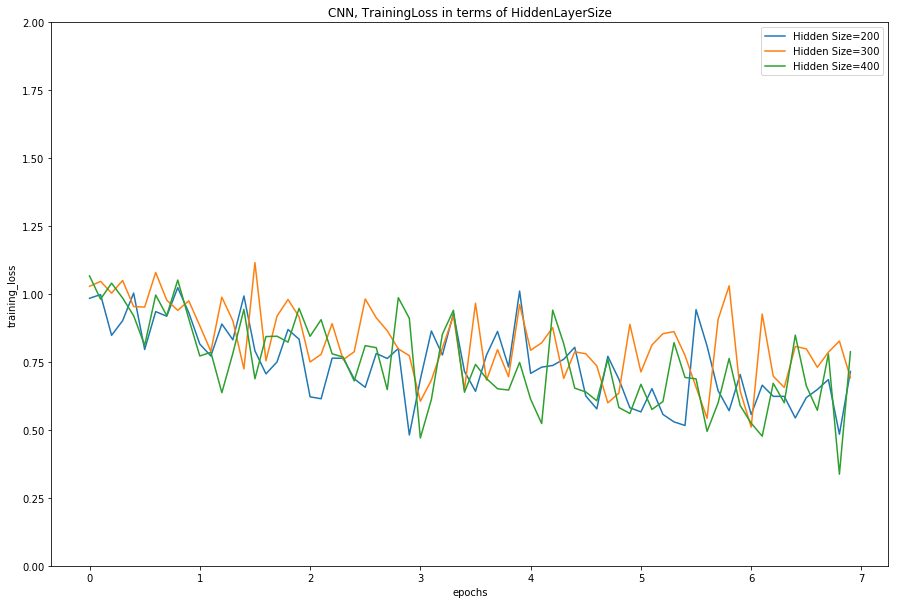

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
maxY = 70
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['trainLoss']['sizeHidLayer']:
        y = data
        label = "Hidden Size="+str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, TrainingLoss in terms of HiddenLayerSize')
plt.xlabel('epochs')
plt.ylabel('training_loss')
plt.ylim(0,2)
plt.show()

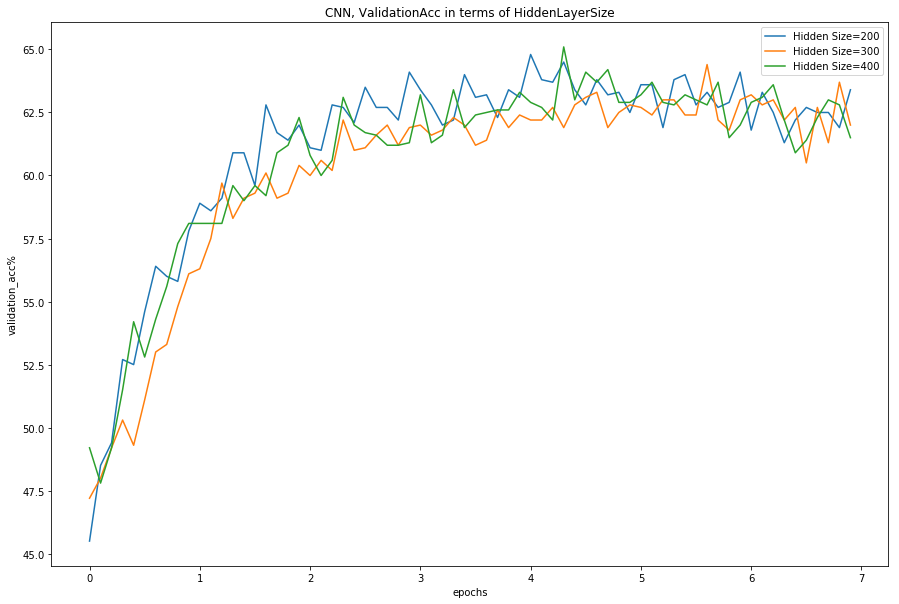

In [88]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['valAcc']['sizeHidLayer']:
        y = data
        label = "Hidden Size="+str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, ValidationAcc in terms of HiddenLayerSize')
plt.xlabel('epochs')
plt.ylabel('validation_acc%')
#plt.ylim(0,45)
plt.show()

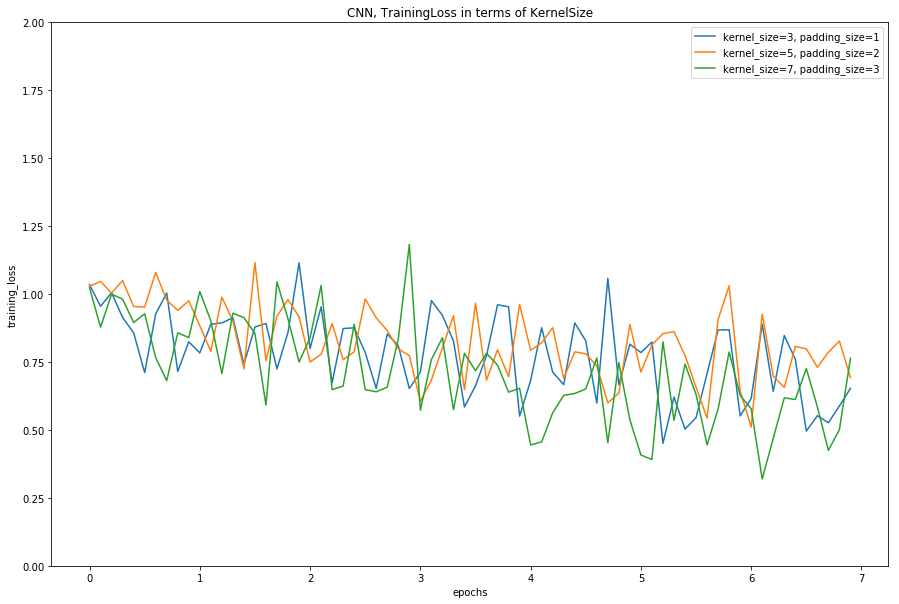

In [96]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
maxY = 70
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['trainLoss']['kernelSize']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, TrainingLoss in terms of KernelSize')
plt.xlabel('epochs')
plt.ylabel('training_loss')
plt.ylim(0,2)
plt.show()

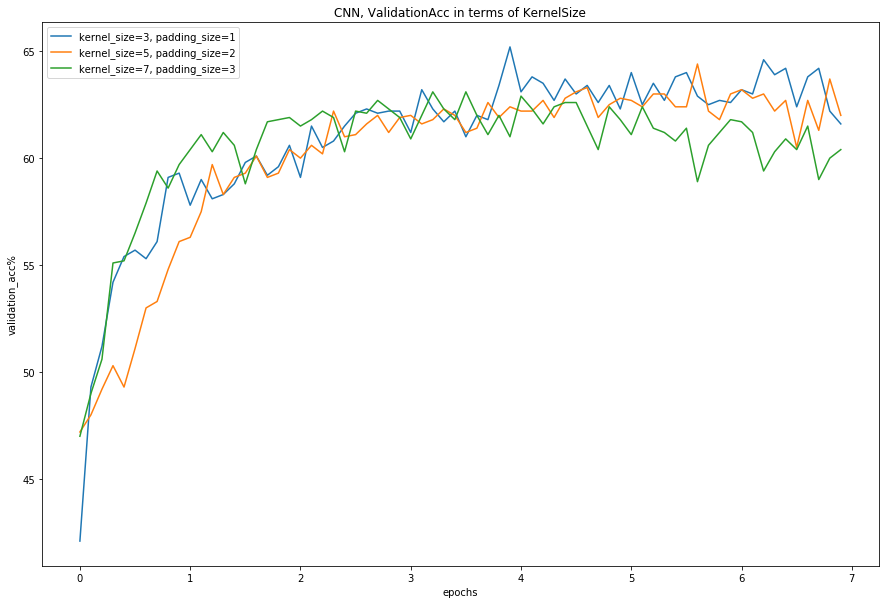

In [97]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['valAcc']['kernelSize']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, ValidationAcc in terms of KernelSize')
plt.xlabel('epochs')
plt.ylabel('validation_acc%')
#plt.ylim(0,45)
plt.show()

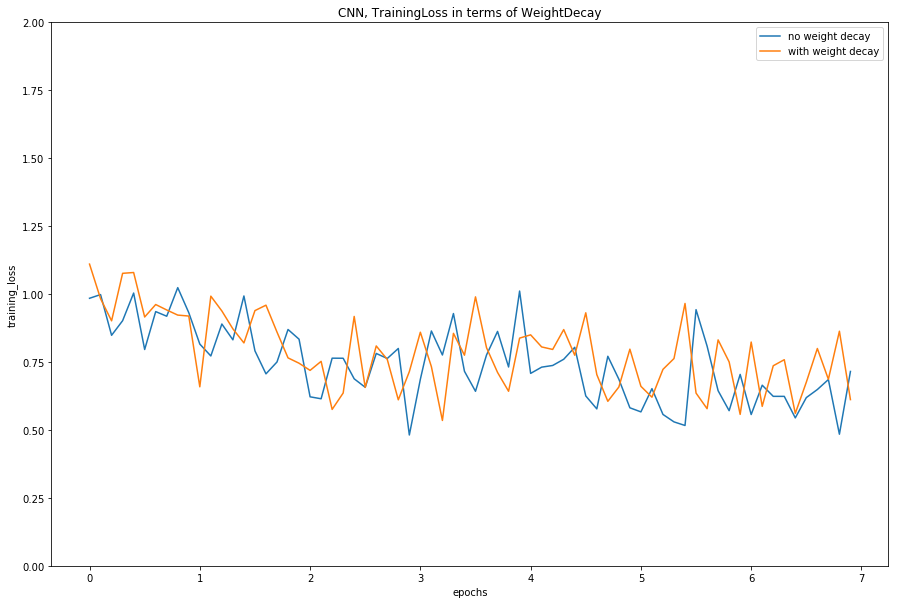

In [98]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
maxY = 70
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['trainLoss']['weightDecay']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, TrainingLoss in terms of WeightDecay')
plt.xlabel('epochs')
plt.ylabel('training_loss')
plt.ylim(0,2)
plt.show()

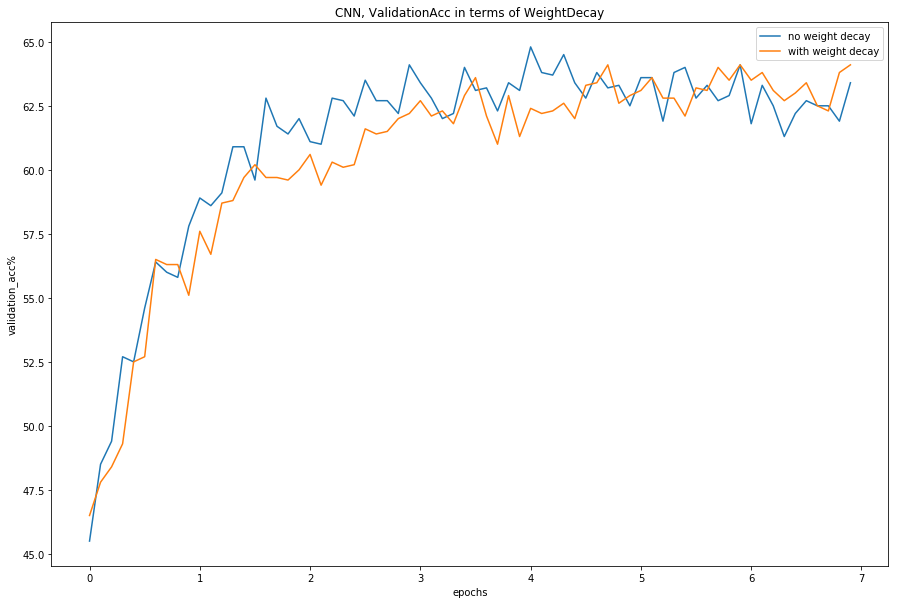

In [99]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['valAcc']['weightDecay']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, ValidationAcc in terms of WeightDecay')
plt.xlabel('epochs')
plt.ylabel('validation_acc%')
#plt.ylim(0,45)
plt.show()

In [10]:
TLConcH200 = pkl_loader(resPath + '/train_loss_list_200_concat0.00020.p')
TLMultH200 = pkl_loader(resPath + '/train_loss_list_200_mult0.00020.p')
TLSubH200 = pkl_loader(resPath + '/train_loss_list_200_sub0.00020.p')
TLSubH50 = pkl_loader(resPath + '/train_loss_list_50_sub0.00020.p')
TLSubH400 = pkl_loader(resPath + '/train_loss_list_400_sub0.00020.p')
TLSubH400WD = pkl_loader(resPath + '/train_loss_list_400_sub0.00020.001.p')

TLConcH200CNN = pkl_loader(resCNN + '/train_ACC_list_200_5_concat0.00020.p')
TLConcH200CNNWD = pkl_loader(resCNN + '/train_ACC_list_200_5_concat0.00020.0001.p')
TLConcH300KN3CNN = pkl_loader(resCNN + '/train_ACC_list_300_3_concat0.00020.p')
TLConcH300CNN = pkl_loader(resCNN + '/train_ACC_list_300_5_concat0.00020.p')
TLConcH400CNN = pkl_loader(resCNN + '/train_ACC_list_400_5_concat0.00020.p')
TLConcH300KN7CNN = pkl_loader(resCNN + '/train_ACC_list_300_7_concat0.00020.p')

In [12]:
from collections import defaultdict
allRnnRes = defaultdict(dict)
allRnnRes['trainLoss']['sizeHidLayer'] = [(TLSubH50, '50'), (TLSubH200, '200'), (TLSubH400, '400')]
allRnnRes['trainLoss']['methodInteract'] = [(TLConcH200, 'Concat'), (TLMultH200, 'Mult'), (TLSubH200, 'Subtra')]
allRnnRes['trainLoss']['weightDecay'] = [(TLSubH400, 'no weight decay'), (TLSubH400WD, 'with weight decay')]
allCnnRes = defaultdict(dict)
allCnnRes['trainLoss']['sizeHidLayer'] = [(TLConcH200CNN, '200'), (TLConcH300CNN, '300'), (TLConcH400CNN, '400')]
allCnnRes['trainLoss']['kernelSize'] = [(TLConcH300KN3CNN, 'kernel_size=3, padding_size=1'), \
                                        (TLConcH300CNN, 'kernel_size=5, padding_size=2'), (TLConcH300KN7CNN, 'kernel_size=7, padding_size=3')]
allCnnRes['trainLoss']['weightDecay'] = [(TLConcH200CNN, 'no weight decay'), (TLConcH200CNNWD, 'with weight decay')]

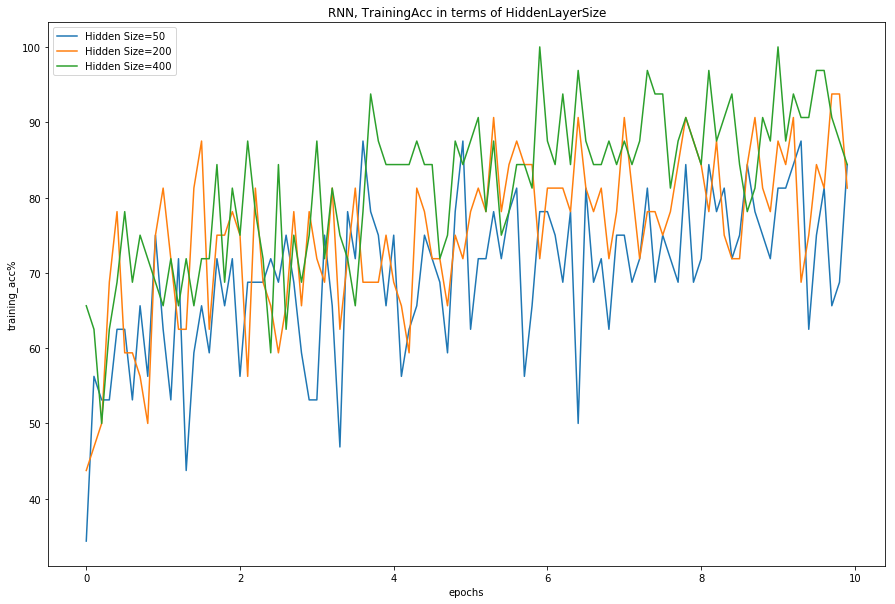

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['trainLoss']['sizeHidLayer']:
        y = data
        label = "Hidden Size="+str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, TrainingAcc in terms of HiddenLayerSize')
plt.xlabel('epochs')
plt.ylabel('training_acc%')
#plt.ylim(0,2)
plt.show()

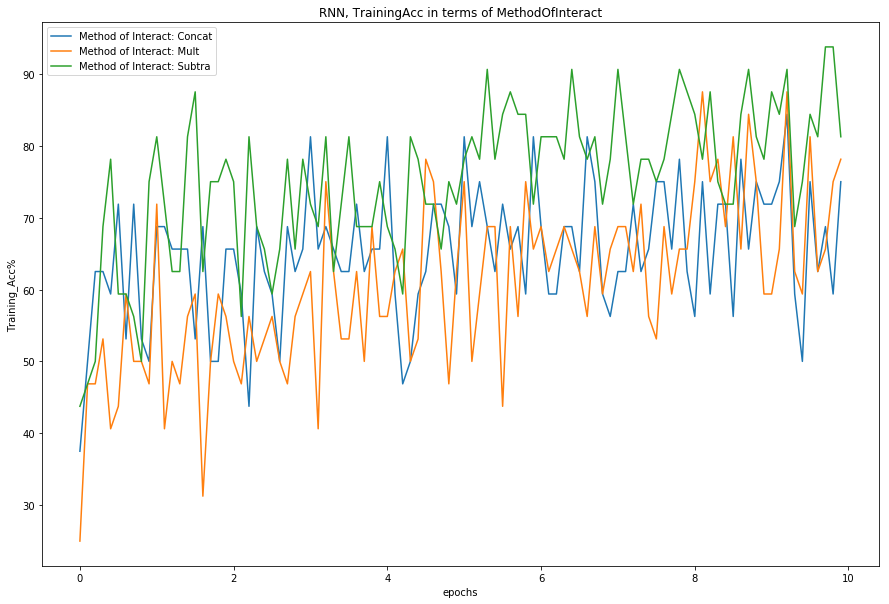

In [15]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['trainLoss']['methodInteract']:
        y = data
        label = "Method of Interact: "+str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, TrainingAcc in terms of MethodOfInteract')
plt.xlabel('epochs')
plt.ylabel('Training_Acc%')
#plt.ylim(0,2)
plt.show()

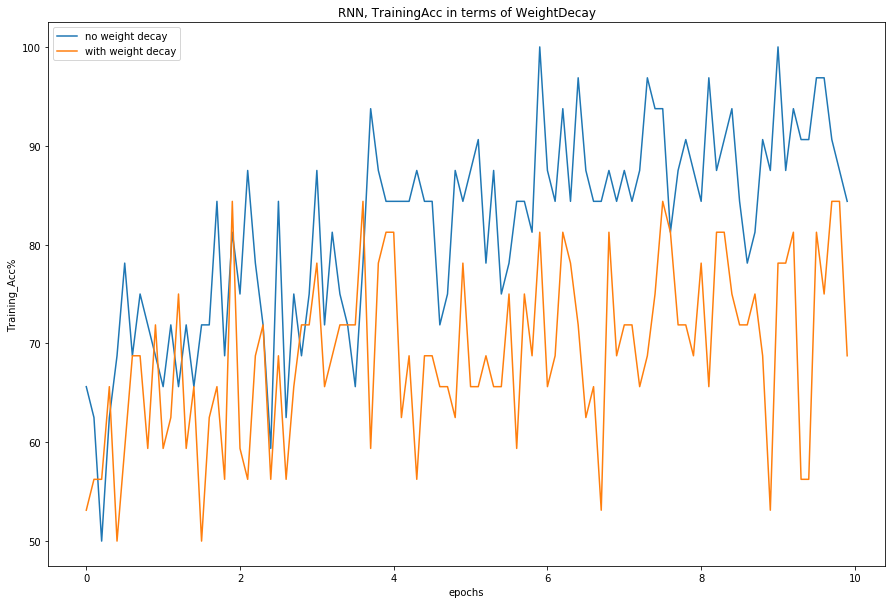

In [16]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allRnnRes['trainLoss']['weightDecay']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('RNN, TrainingAcc in terms of WeightDecay')
plt.xlabel('epochs')
plt.ylabel('Training_Acc%')
#plt.ylim(0,2)
plt.show()

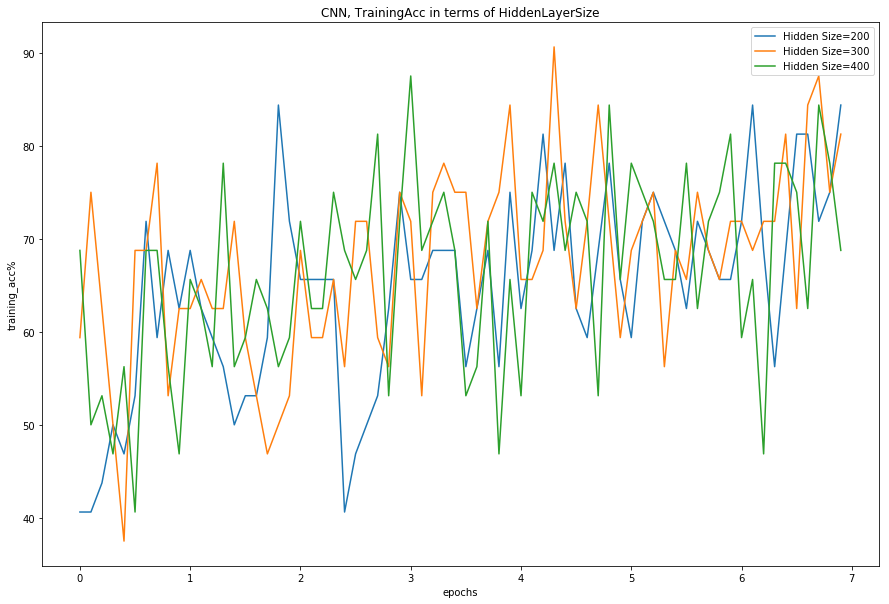

In [17]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
maxY = 70
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['trainLoss']['sizeHidLayer']:
        y = data
        label = "Hidden Size="+str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, TrainingAcc in terms of HiddenLayerSize')
plt.xlabel('epochs')
plt.ylabel('training_acc%')
#plt.ylim(0,2)
plt.show()

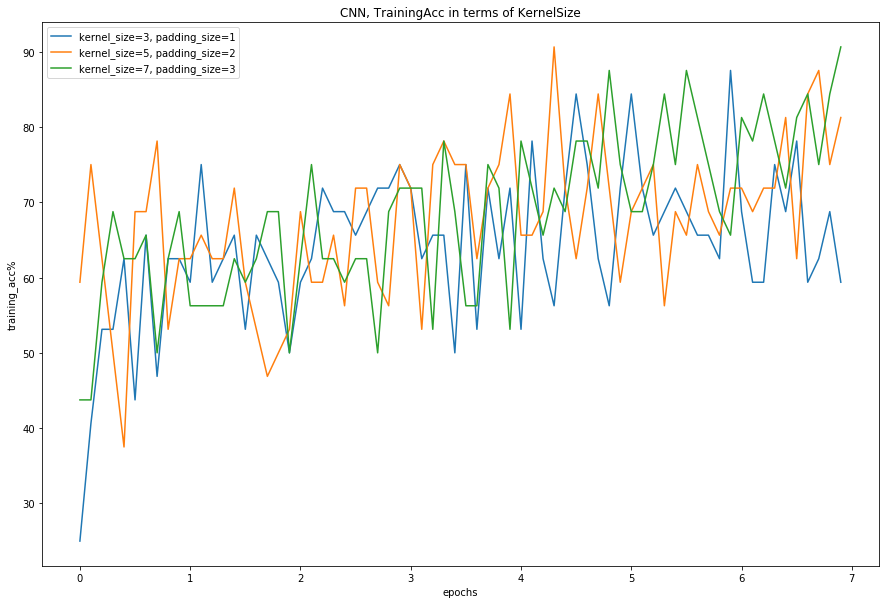

In [18]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
maxY = 70
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['trainLoss']['kernelSize']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, TrainingAcc in terms of KernelSize')
plt.xlabel('epochs')
plt.ylabel('training_acc%')
#plt.ylim(0,2)
plt.show()

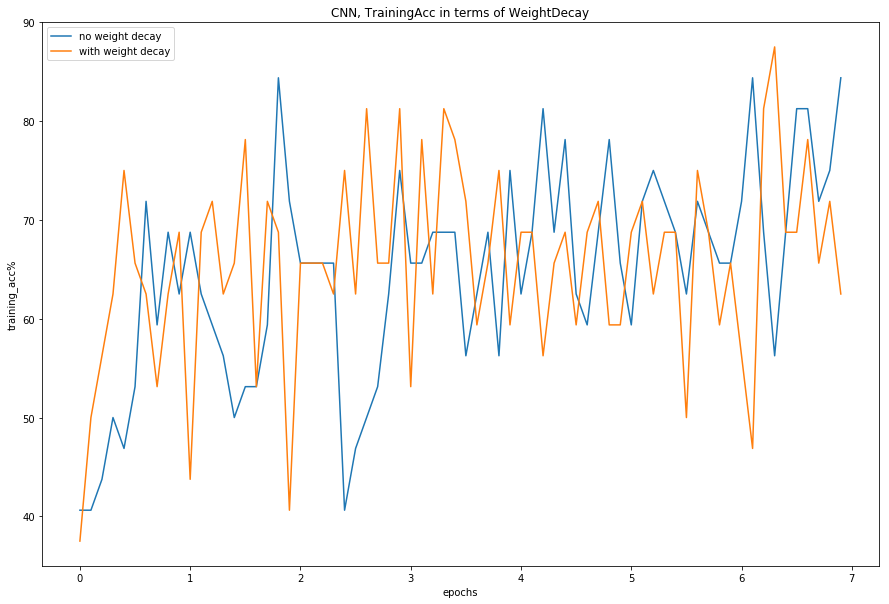

In [20]:
xpts = np.arange(0 , 10, 1/10).reshape(-1,1)
maxY = 70
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for data, param in allCnnRes['trainLoss']['weightDecay']:
        y = data
        label = str(param)
        lines[label],=ax.plot(xpts[:maxY], y[:maxY], label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('CNN, TrainingAcc in terms of WeightDecay')
plt.xlabel('epochs')
plt.ylabel('training_acc%')
#plt.ylim(0,2)
plt.show()

In [100]:
cnnMNLIRes = {}
for genre in train_dataset_M.keys():
    cnnMNLIRes[genre] = test_model(val_loader_MNLI[genre], theBestCnnModel)
cnnMNLIRes['all'] = test_model(val_loader_M_all, theBestCnnModel)

In [101]:
cnnMNLIRes

{'telephone': 42.78606965174129,
 'fiction': 40.301507537688444,
 'slate': 39.321357285429144,
 'government': 43.011811023622045,
 'travel': 41.44602851323829,
 'all': 41.38}

In [102]:
import pandas as pd

In [108]:
MNLI_res = pd.concat([pd.DataFrame(rnnMNLIRes, index = ['RNN']), pd.DataFrame(cnnMNLIRes, index = ['CNN'])])

In [109]:
MNLI_res

,all,fiction,government,slate,telephone,travel
RNN,48.74,49.748744,48.622047,47.105788,48.656716,49.389002
CNN,41.38,40.301508,43.011811,39.321357,42.786070,41.446029
